In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

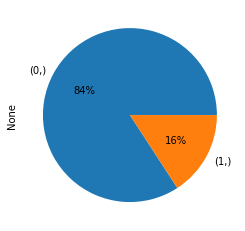

In [3]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

In [4]:
train = pd.read_pickle('train_1123features.pkl') ### 293 features
test = pd.read_pickle('test_1123features.pkl')

In [5]:
train.dtypes.value_counts()

float64    1035
int32        65
int64        23
dtype: int64

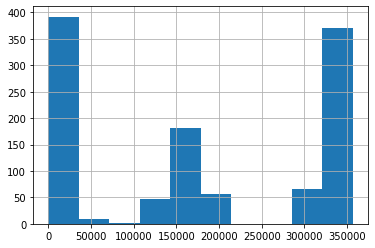

In [6]:
train.isna().sum().hist();

## Entrenando LGBM con hiperparámetros

In [8]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.860437	training's binary_logloss: 0.289712	valid_1's auc: 0.846237	valid_1's binary_logloss: 0.300648
[200]	training's auc: 0.875982	training's binary_logloss: 0.277379	valid_1's auc: 0.851073	valid_1's binary_logloss: 0.296692
[300]	training's auc: 0.88701	training's binary_logloss: 0.268602	valid_1's auc: 0.852077	valid_1's binary_logloss: 0.295892
Early stopping, best iteration is:
[316]	training's auc: 0.888411	training's binary_logloss: 0.2674	valid_1's auc: 0.852183	valid_1's binary_logloss: 0.295783
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.860119	training's binary_logloss: 0.290054	valid_1's auc: 0.845933	valid_1's binary_logloss: 0.300787
[200]	training's auc: 0.875718	training's binary_logloss: 0.277459	valid_1's auc: 0.850936	valid_1's binary_logloss: 0.29665
Early stopping, best iteration is:
[215]	tr

In [9]:
fi.sort_values(ascending=False).head(50)

RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.012536
edad                                                 0.011815
cod_instit_financiera_max_ult1mes                    0.010938
cod_ubi                                              0.009025
tip_lvledu                                           0.009009
RIESGO_DIRECTO_-1_saldoUnique_ult12meses             0.008270
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.007822
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.007621
RIESGO_DIRECTO_-1_saldoMedian_ult1meses              0.007401
sit_lab                                              0.007359
cod_instit_financiera_min_ult1mes                    0.007296
ubigeo_mode                                          0.006599
prv                                                  0.006474
RIESGO_DIRECTO_-1_saldoMedian_ult2meses              0.006309
sexo                                                 0.006177
RIESGO_DIRECTO_1_saldoMin_ult1meses                  0.005966
flg_sin_

In [10]:
fi.to_pickle('fi_lightgbm.pkl')

In [11]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

## Entrenando CatBoost con hiperparámetros

In [12]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(boosting_type = 'Plain', n_estimators=1000, eval_metric = 'AUC',
                   colsample_bylevel=1, subsample=1, learning_rate=0.3, max_bin=100)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
0:	test: 0.7314209	test1: 0.7380100	best: 0.7380100 (0)	total: 493ms	remaining: 8m 12s
100:	test: 0.8537781	test1: 0.8434292	best: 0.8434292 (100)	total: 59.8s	remaining: 8m 52s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8466630881
bestIteration = 186

Shrink model to first 187 iterations.
********** 1 **********
0:	test: 0.7335167	test1: 0.7317035	best: 0.7317035 (0)	total: 508ms	remaining: 8m 27s
100:	test: 0.8542764	test1: 0.8442949	best: 0.8442949 (100)	total: 1m 1s	remaining: 9m 9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8462962326
bestIteration = 157

Shrink model to first 158 iterations.
********** 2 **********
0:	test: 0.7318044	test1: 0.7382914	best: 0.7382914 (0)	total: 506ms	remaining: 8m 25s
100:	test: 0.8530233	test1: 0.8460448	best: 0.8460608 (99)	total: 1m 4s	remaining: 9m 35s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8480239794
bestIteration = 152

Shrink model to firs

In [13]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoMean_ult1meses       0.106500
COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult1meses     0.077204
tip_lvledu                                           0.018709
COD_CLASIFICACION_DEUDOR_5_saldoMedian_ult1meses     0.017563
RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.017468
cod_instit_financiera_max_ult8mes                    0.017128
COD_CLASIFICACION_DEUDOR_0_saldoStd_ult1meses        0.014686
edad                                                 0.013720
RIESGO_DIRECTO_-1_saldoMedian_ult1meses              0.013260
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult5meses        0.013040
RIESGO_DIRECTO_2_saldoUnique_ult2meses               0.012917
COD_CLASIFICACION_DEUDOR_5_saldoStd_ult2meses        0.012086
sexo                                                 0.011310
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.011248
flg_sin_email                                        0.010906
RIESGO_DIRECTO_-1_saldoMedian_ult5meses              0.010613
PRODUCTO

In [14]:
fi.to_pickle('fi_catboost.pkl')

In [15]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

## LGBM con Categorical_Feature con hiperparámetros

In [21]:
# aux = ['sexo', 'est_cvl', 'sit_lab', 'cod_ocu', 'flg_sin_email', 'cod_ubi', 'lgr_vot', 'prv', 'dto', 'rgn', 'tip_lvledu']
# var_mode = [(n,i) for n,i in enumerate(train.columns) if 'mode' in i or i in aux]
# categorical_feature_index = []
# for n,i in var_mode:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')
#     categorical_feature_index.append(str(n))
# categorical_feature_values = [ i for n,i in var_mode]
# fit_params={'categorical_feature': categorical_feature_values}

In [38]:
var_mode = [ i for i in train.columns if 'mode' in i ]
for i in var_mode:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

In [40]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, 
                             colsample_bytree=0.8,subsample=0.8, max_bin=200, learning_rate=0.1)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=50) # **fit_params
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.854701	training's binary_logloss: 0.296407	valid_1's auc: 0.83685	valid_1's binary_logloss: 0.307919
[100]	training's auc: 0.871102	training's binary_logloss: 0.282818	valid_1's auc: 0.844701	valid_1's binary_logloss: 0.301686
[150]	training's auc: 0.881778	training's binary_logloss: 0.274074	valid_1's auc: 0.84755	valid_1's binary_logloss: 0.299355
[200]	training's auc: 0.890038	training's binary_logloss: 0.267316	valid_1's auc: 0.848697	valid_1's binary_logloss: 0.298322
[250]	training's auc: 0.89705	training's binary_logloss: 0.261404	valid_1's auc: 0.849508	valid_1's binary_logloss: 0.297782
Early stopping, best iteration is:
[252]	training's auc: 0.897273	training's binary_logloss: 0.261191	valid_1's auc: 0.849549	valid_1's binary_logloss: 0.297721
********** 1 **********
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.855058	training's binary_logloss: 0.296518	v

In [41]:
fi.sort_values(ascending=False).head(50)

ciiu_mode                                            0.114273
cod_instit_financiera_mode_ult1mes                   0.047966
ubigeo_mode                                          0.038774
cod_instit_financiera_mode_ult12mes                  0.031577
cod_instit_financiera_mode_ult2mes                   0.027748
cod_instit_financiera_mode_ult3mes                   0.020124
cod_instit_financiera_mode_ult4mes                   0.016227
cod_instit_financiera_mode_ult11mes                  0.015911
cod_instit_financiera_mode_ult10mes                  0.015338
cod_instit_financiera_mode_ult5mes                   0.013591
cod_instit_financiera_mode_ult7mes                   0.013182
cod_instit_financiera_mode_ult6mes                   0.012411
cod_instit_financiera_mode_ult8mes                   0.012292
RIESGO_DIRECTO_1_saldoUnique_ult1meses               0.012208
cod_instit_financiera_mode_ult9mes                   0.012001
edad                                                 0.009273
tip_lvle

In [42]:
fi.to_pickle('fi_lightgbm_cf.pkl')

In [43]:
train_probs_lightgbm_cf = train_probs
test_probs_lightgbm_cf= test_probs
train_probs_lightgbm_cf.to_pickle('train_probs_lightgbm_cf.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_lightgbm_cf.pkl')

## Manejo de Missing Values y Standarizacion

In [14]:
var_categ = [i for i in train.columns if 'mode' in i]
var_categ.extend(['sexo', 'est_cvl', 'sit_lab', 'cod_ocu', 'flg_sin_email', 'cod_ubi', 'lgr_vot', 'prv', 'dto', 'rgn', 'tip_lvledu'])
for i in var_categ:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0])

In [15]:
var_cuanti = list(set(train.columns).difference(var_categ))
for i in var_cuanti:
    train[i] = train[i].fillna(train[i].median())
    test[i] = test[i].fillna(train[i].median())

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [17]:
train = pd.DataFrame(train_scaled, index=train.index, columns=train.columns)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)

## Entrenando RandomForestClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = RandomForestClassifier(n_estimators=500, criterion='gini', n_jobs=8, verbose=True,
             random_state=407, oob_score=True)
    
    learner.fit(Xt, yt)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  8.0min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 18.4min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 20.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   21.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   50.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   58.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   10.4s finished


********** 1 **********


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 18.1min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 20.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   22.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   52.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   11.0s finished


********** 2 **********


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 18.0min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 20.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   55.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   11.2s finished


********** 3 **********


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 16.7min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 19.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   55.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   10.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   11.5s finished


********** 4 **********


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 18.3min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed: 21.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   23.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   53.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    9.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:   10.7s finished


*********************
roc auc estimado:  0.8146696429928888
roc auc varianza:  0.0009122445623507551


In [29]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoMedian_ult1meses     0.007087
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult6meses        0.006830
COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses        0.006723
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult2meses        0.006568
COD_CLASIFICACION_DEUDOR_5_saldoMean_ult1meses       0.006536
COD_CLASIFICACION_DEUDOR_5_saldoMax_ult1meses        0.006252
condicion_9_saldoSum_ult1meses                       0.005845
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult7meses        0.005770
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult8meses        0.004847
condicion_9_saldoSum_ult12meses                      0.004768
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult5meses        0.003779
COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult11meses    0.003766
COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult10meses    0.003720
COD_CLASIFICACION_DEUDOR_3_saldoMin_ult4meses        0.003478
COD_CLASIFICACION_DEUDOR_5_saldoMean_ult9meses       0.003377
edad                                                 0.003247
cod_ubi 

In [23]:
fi.to_pickle('fi_randomforrest.pkl')

In [21]:
train_probs_randomforrest = train_probs
test_probs_randomforrest = test_probs
train_probs_randomforrest.to_pickle('train_probs_randomforrest.pkl')
test_probs_randomforrest.to_pickle('test_probs_randomforrest.pkl')

## Entrenando GradientBosstingClassifier

In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.fit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, subsample=0.8,
                                         max_depth=5, verbose=1, max_features=0.82, random_state=407,
                                         n_iter_no_change = 10, tol=0.01, validation_fraction = 0.2)
   
    learner.fit(Xt, yt)        
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8321           0.0388          378.59m
         2           0.8091           0.0233          373.85m
         3           0.7922           0.0172          369.09m
         4           0.7763           0.0143          364.49m
         5           0.7660           0.0131          360.65m
         6           0.7542           0.0101          361.26m
         7           0.7452           0.0084          359.68m
         8           0.7344           0.0095          357.16m
         9           0.7283           0.0066          358.04m
        10           0.7215           0.0062          359.43m
        20           0.6699           0.0028          354.02m
        30           0.6478           0.0012          347.56m
        40           0.6287           0.0008          335.42m
********** 1 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1          

In [25]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoSum_ult2meses        0.087982
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult8meses        0.075562
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult7meses        0.051145
COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult11meses    0.050670
condicion_9_saldoSum_ult1meses                       0.036233
cod_instit_financiera_max_ult1mes                    0.032778
COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult10meses    0.031949
RIESGO_DIRECTO_2_saldoSum_ult2meses                  0.028899
COD_CLASIFICACION_DEUDOR_1_saldoMin_ult2meses        0.021091
tipo_credito_12_saldoSum_ult1meses                   0.019191
tipo_credito_11_saldoUnique_ult12meses               0.018177
COD_CLASIFICACION_DEUDOR_5_saldoMedian_ult1meses     0.016533
tipo_credito_11_saldoMean_ult1meses                  0.016202
COD_CLASIFICACION_DEUDOR_5_saldoMax_ult1meses        0.016034
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.015525
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult12meses       0.014678
cod_inst

In [26]:
fi.to_pickle('fi_gbc.pkl')

In [27]:
train_probs_gbc = train_probs
test_probs_gbc = test_probs
train_probs_gbc.to_pickle('train_probs_gbc.pkl')
test_probs_gbc.to_pickle('test_probs_gbc.pkl')

In [33]:
train.dtypes.value_counts()

float64    1123
dtype: int64